# Imports

In [45]:
import os
import pandas as pd
import radiomics
from radiomics import featureextractor
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import random
import SimpleITK as sitk 
import re
import json
import math
from PIL import Image, ImageDraw
from matplotlib.lines import Line2D
import cv2
import shutil

# Funcionamiento detallado para el paciente numero 29

In [46]:
dirBaseDatos = "../PacienteEjemplo/"
paciente = 29

## Importacion de datos

Se guardan los datos de los dicoms con pydicom y se hace un registro de los errores

In [47]:
dir_CT = os.path.join(dirBaseDatos, str(paciente), r"CT/")
dir_PET = os.path.join(dirBaseDatos, str(paciente), r"PET/")

files = {"CT": [], "PET": []}
damaged_files = {"CT": [], "PET": []}

# Leer imágenes CT y PET
for f in os.listdir(dir_CT):
    try:
        ds = pydicom.dcmread(os.path.join(dir_CT, f))
        if ds.pixel_array is None:
            raise ValueError("Pixel data is missing or empty.")
        files["CT"].append(ds)
    except:
        damaged_files["CT"].append(f)

for f in os.listdir(dir_PET):
    try:
        ds = pydicom.dcmread(os.path.join(dir_PET, f))
        if ds.pixel_array is None:
            raise ValueError("Pixel data is missing or empty.")
        files["PET"].append(ds)
    except:
        damaged_files["PET"].append(f)

damaged_files["CT"] = sorted(damaged_files["CT"])
damaged_files["PET"] = sorted(damaged_files["PET"])

if ((len(damaged_files["PET"]) != 0 ) | (len(damaged_files["CT"]) != 0 )): print("Damaged files")
else: print ("No damaged files")
if (len(damaged_files["CT"]) != 0 ): print(f"\nCT Error: \n{damaged_files['CT']}")
if (len(damaged_files["PET"]) != 0 ): print(f"\nPET Error: \n{damaged_files['PET']}")

No damaged files


Se importa el RTSTRUCT

In [48]:
dir_RTSTRUCT = os.path.join(dirBaseDatos, str(paciente), r"I1")

# Lee el archivo RTSTUCT que s e supone que es un dcm
ds = pydicom.dcmread(dir_RTSTRUCT)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 182
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Structure Set Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.80.333403984.2863.1668414751.3
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.263
(0002, 0013) Implementation Version Name         SH: 'NUEVO_1_0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20221114'
(0008, 0013) Instance Creation Time              TM: '093231'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.80.333403984.2863.1668414751.3
(0008, 002

Se muestran 6 imagenes aleatorias para comprobar la correcta importación de los archivos

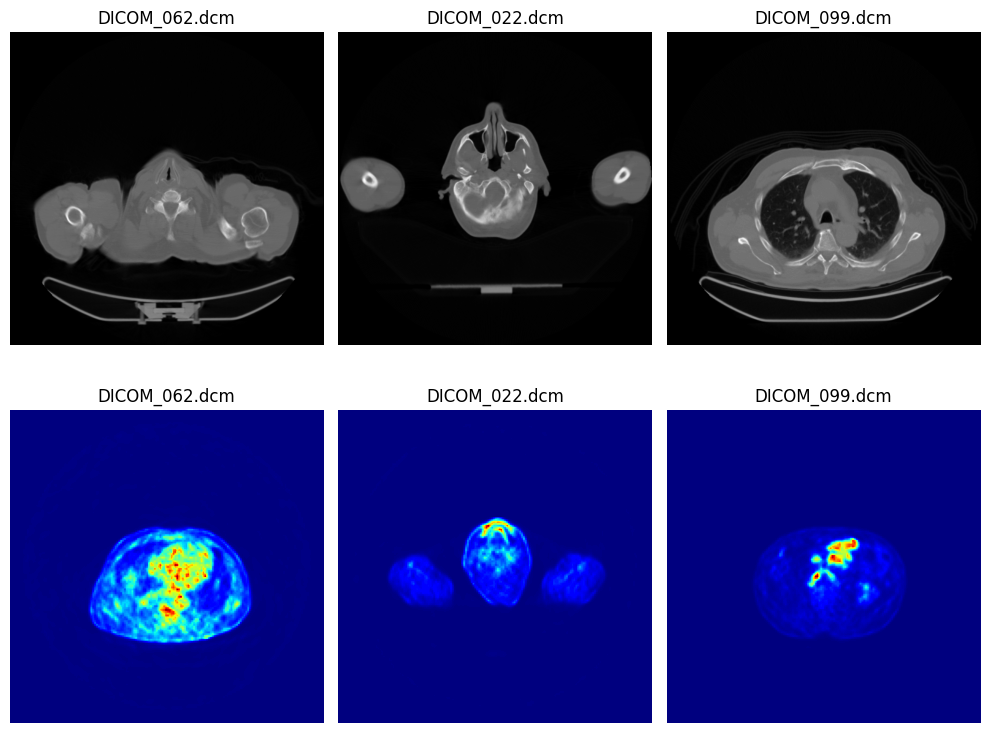

In [49]:
random_images = random.sample([img for img in os.listdir(dir_PET) if img not in (damaged_files["CT"] or damaged_files["PET"])], 3)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
for i, image in enumerate(random_images):
    pet = pydicom.dcmread(os.path.join(dir_PET, image))
    ct = pydicom.dcmread(os.path.join(dir_CT, image))
    col = i % 3
    axs[0, col].imshow(ct.pixel_array, cmap=plt.cm.gray)
    axs[0, col].set_title(f"{image}")
    axs[1, col].imshow(pet.pixel_array, cmap=plt.cm.jet)
    axs[1, col].set_title(f"{image}")
    axs[0, col].axis("off")
    axs[1, col].axis("off")

plt.tight_layout()
plt.show()

## Creación de funciones

#### Funciones auxiliares

In [50]:
def extraerROIName(roi):
    # Define el patrón para encontrar las líneas que empiezan por "(0008, 1155)"
    patron = re.compile(r"\((3006, 0084)\)\s+Referenced ROI Number\s+IS:\s+'?(\d+)'?")
    name = patron.search(str(roi)).group(2)
    
    return name

In [51]:
def extraerUI(ds):
    # Buscar el patrón deseado usando expresiones regulares
    patron = re.compile(r'\(0008, 1155\) Referenced SOP Instance UID\s+UI:\s+(.*)\n')
    resultados = patron.findall(str(ds))

    return resultados

Funcion que toma como entrada un ct dicom para extraer las coordenadas de la imagen, devuelve una lista de numeros en punto foltante que son las coordenadas.

In [77]:

def obtener_Coordenadas(ct):
    patron = re.compile(r"\((0020, 0032)\)\s+Image Position \(Patient\)\s+DS:\s+(.*)")
    coordenadas = patron.search(str(ct)).group(2)
    coordenadas = coordenadas.strip("[]").split(",")
    coordenadas = [float(coord.strip()) for coord in coordenadas]

    return coordenadas

Argumentos de entrada: numero_en_archivo_dicom y UI_Contornos(diccionario de los contornos de interes, ROIs asociados al DICOM) <br>
Primero utiliza la función "obtener_Coordenadas_CT" para obtener la coordenada del plano de imagen de la posición de la imagen del archivo DICOM.  <br>
Luego, busca en el diccionario "UI_Contornos" cualquier ROI que tenga el mismo plano de imagen y agrega la clave externa y la posición de cada ROI correspondiente a dos listas separadas. <br>
Finalmente, devuelve las dos listas.

In [82]:
def obtener_ROIs_y_posicion_del_Dicom (numero_en_archivo_dicom, UI_Contornos):
    r = []
    pos = []
    dicom = pydicom.dcmread(f"../PacienteEjemplo/{paciente}/CT/DICOM_{str(numero_en_archivo_dicom).zfill(3)}.dcm")
    plano = obtener_Coordenadas(dicom)[2]
    
    for clave_externa in UI_Contornos:
        for i, cont in enumerate(UI_Contornos[clave_externa], 0):
            if (plano == cont[0][2]):
                r.append(clave_externa)
                pos.append(i)
    return r, pos

In [101]:
def obtener_PET_del_CT (numero_CT_en_archivo_dicom, UI_Contornos):
    CT = pydicom.dcmread(f"../PacienteEjemplo/{paciente}/CT/DICOM_{str(numero_CT_en_archivo_dicom).zfill(3)}.dcm")
    planoCT = obtener_Coordenadas(CT)[2]

    for nombrePet in os.listdir(dir_PET):
        resultado = None
        PET = pydicom.dcmread(f"../PacienteEjemplo/{paciente}/PET/{nombrePet}")
        planoPET = obtener_Coordenadas(PET)[2]
        if (planoPET == planoCT):
            print(nombrePet.split("_")[1].split(".")[0])
        
    return resultado

obtener_PET_del_CT('005', UI_Contornos)

003


#### Funcion para mostrar los contours por pantalla

**Cabe destacar**

Un tipo geométrico de  CLOSED_PLANAR (3006,0042) indica que el último punto debe estar conectado al primer punto, donde el primer punto no se repite en los datos del contorno Contour Data (3006,0050). Todos los puntos en los datos del contorno Contour Data (3006,0050) deben estar en el mismo plano. (En este caso siempre tienen la misma "z")
La posición de la imagen (0020,0032) especifica las coordenadas x, y y z de la esquina superior izquierda de la imagen; es el centro del primer voxel transmitido. La orientación de la imagen (0020,0037) especifica los cosenos de dirección de la primera fila y la primera columna con respecto al paciente. Estos atributos deben proporcionarse como un par. El valor de fila para los ejes x, y y z, respectivamente, seguido del valor de columna para los ejes x, y y z, respectivamente.

La dirección de los ejes está definida completamente por la orientación del paciente.

Si el Tipo de Orientación Anatómica (0010,2210) **está ausente** o tiene un valor de BÍPEDO, el eje x está aumentando hacia el lado izquierdo del paciente. El eje y está aumentando hacia la parte posterior del paciente. El eje z está aumentando hacia la cabeza del paciente.

Dado que los cosenos de dirección de la primera fila y la primera columna están dados por [1, 0, 0, 0, 1, 0], podemos deducir que la primera fila corresponde al eje x y la primera columna corresponde al eje y. Por lo tanto, la imagen se encuentra en un plano coronal (es decir, la sección transversal del cuerpo humano que divide el cuerpo en una sección anterior y una posterior).

Las coordenadas dadas en (0020, 0032) representan la ubicación del centro del primer voxel transmitido, que está ubicado en la esquina superior izquierda de la imagen. Por lo tanto, podemos deducir que la imagen se extiende hacia la derecha (en la dirección positiva del eje x) desde la ubicación del voxel central, hacia la parte posterior del paciente (en la dirección negativa del eje y), y hacia la cabeza del paciente (en la dirección positiva del eje z).

In [54]:
def __mostrarImagenColores(contorno, colores, numero_dicom, x_imagen, y_imagen, img, path, roi, array_ROI, leyenda, nombres_ROI):

    for i, roiName in enumerate(nombres_ROI):
        if (roi == roiName):
            color = colores[i]
    
    leyenda[color] = roi
    
    # Escalar las coordenadas para que se ajusten a la imagen
    scaled_contorno = []
    for x, y in contorno:
        x = (x - x_imagen)
        y = (y - y_imagen)
        scaled_contorno.append((x, y))

    # Crear un objeto de dibujo
    draw = ImageDraw.Draw(img)

    # Dibujar el contorno en la imagen
    draw.polygon(scaled_contorno, outline=color, fill=color)

    # Convertir la imagen en un array de NumPy
    img_array = plt.imread(path)

    # Mostrar la imagen con el contorno dibujado
    plt.imshow(img_array)
    plt.fill([x for x, y in scaled_contorno], [y for x, y in scaled_contorno], color=color)
    plt.axis('off')

    # Abro solo la ultima imagen
    if (roi == array_ROI[len(array_ROI)-1]):
        # Definir los colores y sus etiquetas
        labels = [f"ROI {value}" for color, value in leyenda.items()]
        # Crear una lista de líneas
        lines = [Line2D([0], [0], color=color, lw=2) for color in leyenda.keys()]
        # Crear la figura y el objeto de los ejes
        fig_leg = plt.figure(figsize=(1, 1))
        ax = fig_leg.add_subplot(111)
        # Añadir las líneas al objeto de los ejes
        for line in lines:
            ax.add_artist(line)
        # Definir los límites de los ejes y los títulos
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        # Añadir la leyenda
        ax.legend(lines, labels, loc='center', frameon=False, handlelength=1, handletextpad=0.5)

        # Mostrar la figura
        plt.show()
        img.show()

    return plt.gcf() # Devolver la figura de la imagen con los contornos dibujados


def mostrarImagenColores(numero_dicom, UI_Contornos, nombres_ROI):
    leyenda = {}
    path = f"../PacienteEjemplo/ImagenesEjemplo/DICOM_{str(numero_dicom).zfill(3)}.dcm.jpg"
    dicom = pydicom.dcmread(f"../PacienteEjemplo/{paciente}/CT/DICOM_{str(numero_dicom).zfill(3)}.dcm")
    coordenadas = obtener_Coordenadas_CT(dicom)
    x_imagen = coordenadas[0]
    y_imagen = coordenadas[1]

    # Cargar la imagen
    img = Image.open(path)

    # Definir las coordenadas de los contornos
    r, pos = obtener_ROIs_y_posicion_del_Dicom(numero_dicom, UI_Contornos)

    contornos = []

    for i in range(len(r)):
        contornos.append(UI_Contornos[r[i]][pos[i]][:, :-1])

    colores = ["red", "blue", "green", "yellow", "purple", "orange", "pink", "brown", "gray", "black", "white"]

    figs = [] # Almacenar las figuras generadas para cada contorno

    for i, contorno in enumerate(contornos):
        fig = __mostrarImagenColores(contorno, colores, numero_dicom, x_imagen, y_imagen, img, path, r[i], r, leyenda, nombres_ROI)
        figs.append(fig)

### Funcion para obtener la máscara

**Hacer la mascara**:
Función llamada obtenerMascara que toma como argumento el número de un archivo DICOM y devuelve una matriz (array) que representa la máscara correspondiente a los contornos asociados con ese archivo DICOM.

El código utiliza la biblioteca PyDICOM para leer los archivos DICOM y obtener las coordenadas de los contornos asociados con el archivo DICOM en cuestión. Luego, dibuja los contornos en una matriz de ceros utilizando la biblioteca OpenCV. Finalmente, la función combina las matrices de contorno para crear una máscara final.

La máscara final es una matriz de 512 x 512 elementos, donde cada elemento puede ser 0, un solo número entero o una lista de números enteros si algun contorno se solapa en la misma imagen. Los valores de 0 representan píxeles que no están dentro de ningún contorno, mientras que los valores enteros representan píxeles que están dentro de un solo contorno. 

In [55]:
def obtenerMascara(numero_dicom, UI_Contornos):

    dicom = pydicom.dcmread(f"../PacienteEjemplo/{paciente}/CT/DICOM_{str(numero_dicom).zfill(3)}.dcm")
    coordenadas = obtener_Coordenadas_CT(dicom)
    x_imagen = coordenadas[0]
    y_imagen = coordenadas[1]
    
    # Definir las coordenadas de los contornos
    r, pos = obtener_ROIs_y_posicion_del_Dicom(numero_dicom, UI_Contornos)
    
    mRois = {}
    for i in range(len(r)):
        mRois[i] = np.zeros((512, 512), dtype=np.int32)

    contornos = []

    for i in range(len(r)):
        contornos.append(UI_Contornos[r[i]][pos[i]][:, :-1])

    scaled_contornos = [[] for _ in range(len(contornos))]
    for i, contorno in enumerate(contornos):
        for x, y in contorno:
            x = (x - x_imagen)
            y = (y - y_imagen)
            scaled_contornos[i].append((x, y))

    for i in range(len(r)):
        # Dibujar el contorno en la matriz de ceros
        cv2.drawContours(mRois[i], [np.array(scaled_contornos[i], dtype=np.int32)], 0, r[i], -1)

    mascara = np.zeros((512,512), dtype=object)  # crear matriz mascara con ceros

    for k in range(len(mRois)):  # recorrer todas las matrices mRois[i]s
        for i in range(512):  # recorrer filas
            for j in range(512):  # recorrer columnas
                if (mRois[k][i][j] != 0):
                    if (mascara[i][j] == 0):
                        mascara[i][j] = mRois[k][i][j]
                    elif (mascara[i][j] != 0):
                        mascara[i][j] = [mascara[i][j]]
                        mascara[i][j].append(mRois[k][i][j])
                    else:
                        mascara[i][j].append(mRois[k][i][j])

    return mascara

## Creacion de estructuras necesarias

Se guardan todos los datos de cada ROI en el array ROIS

In [56]:
#array para guardar los ROIS
rois = []
# Guarda los ROI
for roi in ds.ROIContourSequence:
    rois.append(roi)

Se mapean los nombres de los ROI

In [57]:
nombres_ROI = []

for roi in rois:
    ROI_name = int(extraerROIName(roi))
    nombres_ROI.append(ROI_name)

## Importación de contornos

In [58]:
UI_Contornos = {}
nombres_ROI = []

# Recorre la lista de 'rois'
for roi in rois:
    
    contour_data_patron = re.compile(r'Contour Data\s+DS:\s+(.*)').findall(str(roi))
    ROI_name = int(extraerROIName(roi))
    UI_Contornos[ROI_name] = []
    nombres_ROI.append(ROI_name)
    posicion = 0

    for cont in contour_data_patron:
        if cont.split()[0] == "Array":
            UI_Contornos[ROI_name].append([-1])
            # Paso a la siguiente posición de UI
            posicion+=1
        else:
            # Busca todos los números en la cadena y conviértelos a flotantes
            cont_values = [float(x) for x in re.findall(r'[-+]?\d*\.\d+|[-+]?\d+', cont)]
            # Divide la lista en sub-listas de 3 elementos cada una
            cont_matrix = [cont_values[i:i+3] for i in range(0, len(cont_values), 3)]
            # Imprime la lista resultante
            cont_matrix = np.array(cont_matrix)
            UI_Contornos[int(extraerROIName(roi))].append(cont_matrix)
            posicion+=1

UI_Contornos

{1: [[-1],
  [-1],
  array([[  -5.37109375, -132.3789062 , -497.000061  ],
         [  -2.44140625, -132.3789062 , -497.000061  ],
         [  -2.44140625, -129.4492188 , -497.000061  ],
         [  -5.37109375, -129.4492188 , -497.000061  ],
         [  -5.37109375, -131.4023438 , -497.000061  ]]),
  [-1],
  [-1],
  array([[  -5.37109375, -132.3789062 , -499.5       ],
         [  -2.44140625, -132.3789062 , -499.5       ],
         [  -2.44140625, -129.4492188 , -499.5       ],
         [  -5.37109375, -129.4492188 , -499.5       ],
         [  -5.37109375, -131.4023438 , -499.5       ]]),
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  [-1],
  array([[ -13.18359375, -205.6210938 , -559.5       ],
         [ -10.25

**Hay un problema**, todas los contornos tienen su array en contour data, pero si el array supera los 15 elementos, no se importa de ninguna manera a python, por lo que tendremos que trabajar con el RTSTRUCT como si fuera un .txt para obtener todos los datos de ContourData <br>
Se les ha asignado un valor de [-1] para poder modificarlos mas adelante

### Procesamiento del RTSTRUCT como .txt

Cada archivo tiene el numero de linea igual al numero de contorur que tiene cada ROI <br>
Es decir, la linea 133 del ROI 1 pertenece a los puntos del contour numero 133 del ROI 1

In [59]:
# Abrir archivo y leer su contenido
with open('./RTSTRUCT.txt', encoding='utf-8') as archivo:
    texto = archivo.read()

# Eliminar caracteres raros
texto_limpio = re.sub('[^A-Za-z0-9().-_,/\n]+', ' ', texto)

# Sobrescribir el archivo original con el texto limpio
with open('./RTSTRUCT.txt', 'w', encoding='utf-8') as archivo:
    archivo.write(texto_limpio)

# Leer el archivo limpio
with open('./RTSTRUCT.txt', 'r') as archivo_limpio:
    # Buscar la línea que contiene 'ManualOverrideMaxThresholdS'
    lineas_restantes = archivo_limpio.readlines()
    indice = lineas_restantes.index(next(linea for linea in lineas_restantes if 'ManualOverrideMaxThresholdS' in linea))

    # Guardar las líneas restantes en un archivo nuevo
    with open('archivo_nuevo.txt', 'w') as archivo_nuevo:
        archivo_nuevo.writelines(lineas_restantes[indice+1:])

# Eliminar las líneas que contienen 'ManualOverrideMaxThresholdS' del archivo nuevo
with open('archivo_nuevo.txt', "r") as f:
    lineas = f.readlines()

new_lines = [line for line in lineas if 'ManualOverrideMaxThresholdS' not in line]

with open('archivo_limpio_sin_lineas.txt', "w") as f:
    f.writelines(new_lines)

os.remove('archivo_nuevo.txt')

# Separa por ROIS

search_string = "0 IS"
input_file = "archivo_limpio_sin_lineas.txt"
output_folder = "ROI_txt"
os.makedirs(output_folder, exist_ok=True)

current_roi_position = 0
current_output_file = os.path.join(output_folder, f"{nombres_ROI[current_roi_position]}.txt")
current_group_text = ""
penultimo_roi = 0

with open(input_file, "r") as f:
    for i, line in enumerate(f, 1):  # Agrega el argumento "1" al enumerate para empezar en la línea 1
        if (search_string in line):
            if current_group_text:
                with open(current_output_file, "w") as f_out:
                    f_out.write(current_group_text)

                current_group_text = ""
                current_roi_position += 1
                current_output_file = os.path.join(output_folder, f"{nombres_ROI[current_roi_position]}.txt")
        else:
            current_group_text += line

if current_group_text:
    with open(current_output_file, "w") as f_out:
        f_out.write(current_group_text)

# Guardar el ultimo ROI

search_string = f"0 IS {str(nombres_ROI[len(nombres_ROI)-2])}"
input_file = "archivo_limpio_sin_lineas.txt"
output_file = f"./ROI_txt/tempLast.txt"

start_writing = False

with open(input_file, "r") as f_in, open(output_file, "w") as f_out:
    for line in f_in:
        if search_string in line:
            start_writing = True
            continue
        if start_writing:
            f_out.write(line)

with open(output_file, "r") as f, open(f"./ROI_txt/{str(nombres_ROI[len(nombres_ROI)-1])}.txt", "w") as output:
    for line in f:
        if len(line.split("\\")) > 1 and any(char.isdigit() for char in line.split("\\")[1]) and "UI" not in line:
            # línea contiene números entre \\ y no contiene "UI", agregar al archivo de salida
            output.write(line)

os.remove(output_file)

# Filtrar los saltos de linea no esperados

input_dir = "./ROI_txt/"
output_dir = "./ROI_txt/"

for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        in_F = os.path.join(input_dir, filename)
        out_F = os.path.join(output_dir, f"ROI_{filename}")

        with open(in_F, "r") as archivo:
            lineas = archivo.readlines()

        with open(out_F, "w") as archivo_modificado:
            for linea in lineas:
                if re.search(r"0P\s\S*\n", linea):
                    linea = linea.replace("\n", " ")
                archivo_modificado.write(linea)

        os.remove(in_F)

# Dejar solo las lineas de los Contours

input_dir = "./ROI_txt/"
output_dir = "./ROI_txt/"

for filename in os.listdir(input_dir):
    if filename.endswith(".txt"):
        input_file = os.path.join(input_dir, filename)
        output_file = os.path.join(output_dir, f"f{filename}")

        with open(input_file, "r") as f_in, open(output_file, "w") as f_out:
            filtered_lines = filter(lambda line: line.find("CLOSED_PLANAR") != -1, f_in)
            f_out.writelines(filtered_lines)

        with open(input_file, "r") as f_in, open(output_file, "w") as f_out:
            for line in f_in:
                words = line.split()
                try:
                    index_0p = words.index("0P")
                    new_line = " ".join(words[index_0p+2:])
                except ValueError:
                    new_line = line
                f_out.write(new_line)

        os.remove(input_file)

os.remove("archivo_limpio_sin_lineas.txt")

### Paso todos los contornos restantes a UI_Contornos

In [60]:
for clave_externa in UI_Contornos:
    with open(f"./ROI_txt/fROI_{clave_externa}.txt", "r") as archivo:
        lineas = archivo.readlines()

    for i, cont in enumerate(UI_Contornos[clave_externa], 0):
        if (len(cont) == 1):
            try:
                numeros = re.findall(r'\d+(?:\.\d+)?', lineas[i][:lineas[i].index("0 SQ")])
            except ValueError:
                numeros = re.findall(r'\d{1,3}(?:\.\d{1,3})?', lineas[i])
            except IndexError:
                pass

            
            numeros = np.array(numeros)
            numeros = np.negative(numeros.astype(np.float64))
            n_pad = 3 - len(numeros) % 3
            if n_pad < 3:
                numeros = np.pad(numeros, (0, n_pad), mode='constant', constant_values=0)
                
            numeros = numeros.reshape(-1, 3)

            UI_Contornos[clave_externa][i] = numeros

# Borro los archivos de texto sobrantes
shutil.rmtree("./ROI_txt/")

UI_Contornos

{1: [array([[  -1.46484375, -152.8867188 , -497.000061  ],
         [  -6.34765625, -152.8867188 , -497.000061  ],
         [  -6.34765625, -142.1445312 , -497.000061  ],
         [  -2.44140625, -142.1445312 , -497.000061  ],
         [  -2.44140625, -138.2382812 , -497.000061  ],
         [  -1.46484375, -138.2382812 , -497.000061  ],
         [  -1.46484375, -151.9101562 , -497.000061  ]]),
  array([[ -22.94921875, -145.0742188 , -497.000061  ],
         [ -30.76171875, -145.0742188 , -497.000061  ],
         [ -30.76171875, -129.4492188 , -497.000061  ],
         [ -27.83203125, -129.4492188 , -497.000061  ],
         [ -27.83203125, -138.2382812 , -497.000061  ],
         [ -22.94921875, -138.2382812 , -497.000061  ],
         [ -22.94921875, -144.0976562 , -497.000061  ]]),
  array([[  -5.37109375, -132.3789062 , -497.000061  ],
         [  -2.44140625, -132.3789062 , -497.000061  ],
         [  -2.44140625, -129.4492188 , -497.000061  ],
         [  -5.37109375, -129.4492188 , -

## Test

### Mostrar imagen

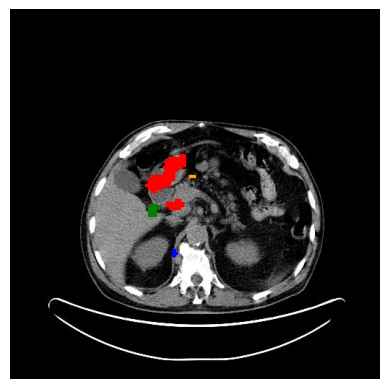

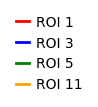

<Figure size 640x480 with 0 Axes>

In [61]:
mostrarImagenColores(165, UI_Contornos, nombres_ROI)

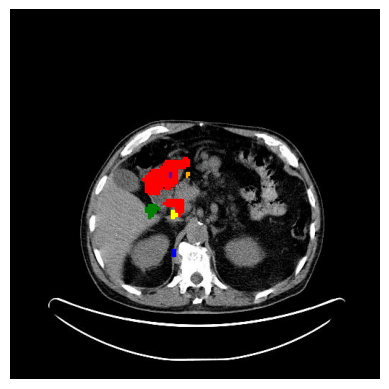

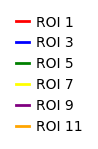

<Figure size 640x480 with 0 Axes>

In [62]:
mostrarImagenColores(166, UI_Contornos, nombres_ROI)

### Obtener mascara

Se muestra para la imagen 166

In [ ]:

mascara166 = obtenerMascara(166, UI_Contornos)

#Muestro la mascara166, ver linea 205
for i in range(len(mascara166)):
    for j in range(len(mascara166[0])):
        if (mascara166[i][j] == 0):
            print(".", end=" ")
        else:
            print(mascara166[i][j], end=" ")
    print()

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

## Guarda todas las mascaras

In [ ]:
mascaras = {}

for f in os.listdir(dir_CT):
    numeroMascara = f.split("_")[1].split(".")[0]
    mascaras[numeroMascara] = obtenerMascara(numeroMascara, UI_Contornos)


In [80]:
obtener_Coordenadas(pet)

[-342.11411916001, -510.44183897182, -962.0]

In [81]:
pet

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Positron Emission Tomography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.264088023912578457719837799841126264731
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002, 0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.264088023912

In [71]:
pet = pydicom.dcmread("../PacienteEjemplo/29/PET/DICOM_166.dcm")

for i in range(len(pet.pixel_array)):
    for j in range(len(pet.pixel_array[i])):
        print(pet.pixel_array[i][j], end=" ")
    print()

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [70]:
shape(pet.pixel_array)

NameError: name 'shape' is not defined

# EN Desarrollo

**Comparación de SuvMAX de las ROIs** 

In [ ]:

# Definir la ruta al directorio que contiene las imágenes DICOM del estudio
ruta_estudio = "D:/TFG_AlejandraMedinaBenito/CosasUtiles/CodigoBueno/TFGAlex"

# Definir una función para obtener el valor SUVmax para una imagen y una ROI
def obtener_SUVmax(imagen, mascara, roi):
    # Obtener los valores de intensidad de píxeles correspondientes a la ROI
    intensidades_roi = imagen[mascara == roi]
    # Calcular el valor SUVmax para la ROI
    SUVmax = np.max(intensidades_roi)
    return SUVmax

# Definir una función para obtener la máscara de una imagen DICOM
def obtenerMascara(ruta_imagen):
    dicom = pydicom.dcmread(ruta_imagen)
    coordenadas = obtener_Coordenadas_CT(dicom)
    x_imagen = coordenadas[0]
    y_imagen = coordenadas[1]
    
    r, pos = obtener_ROIs_y_posicion_del_Dicom(dicom.numero_dicom, UI_Contornos)
    mRois = {}
    for i in range(len(r)):
        mRois[i] = np.zeros((512, 512), dtype=np.int32)

    contornos = []

    for i in range(len(r)):
        contornos.append(UI_Contornos[r[i]][pos[i]][:, :-1])

    scaled_contornos = [[] for _ in range(len(contornos))]
    for i, contorno in enumerate(contornos):
        for x, y in contorno:
            x = (x - x_imagen)
            y = (y - y_imagen)
            scaled_contornos[i].append((x, y))

    for i in range(len(r)):
        cv2.drawContours(mRois[i], [np.array(scaled_contornos[i], dtype=np.int32)], 0, r[i], -1)

    mascara = np.zeros((512,512), dtype=object)
    for k in range(len(mRois)):
        for i in range(512):
            for j in range(512):
                if (mRois[k][i][j] != 0):
                    if (mascara[i][j] == 0):
                        mascara[i][j] = mRois[k][i][j]
                    elif (mascara[i][j] != 0):
                        mascara[i][j] = [mascara[i][j]]
                        mascara[i][j].append(mRois[k][i][j])
                    else:
                        mascara[i][j].append(mRois[k][i][j])
    return mascara

# Crear una lista para almacenar las máscaras de todas las imágenes en el estudio
mascaras = []

# Recorrer todos los archivos DICOM en la ruta del estudio
for archivo in os.listdir(ruta_estudio):
    if archivo.endswith(".dcm"):
        ruta_imagen = os.path.join(ruta_estudio, archivo)
        # Obtener la máscara de la imagen actual y añadirla a la lista
        mascara = obtenerMascara(ruta_imagen)
        mascaras.append(mascara)

# Crear una lista para almacenar los valores SUVmax para todas las imágenes y ROIs
SUVmax_list = []
print (SUVmax_list)

# Recorrer todas las máscaras y todas las ROIs en cada máscara
for i, mascara in enumerate(mascaras):
    imagen



## cosas utiles

In [ ]:
pet_study = pydicom.dcmread('D:/TFG_AlejandraMedinaBenito/CosasUtiles/BaseDatos/29/PET/DICOM_001.dcm')

In [ ]:
# Obtener las coordenadas de cada ROI y los valores de SUV correspondientes del estudio PET
rois = {}


for roi in ds.ROIContourSequence:
    roi_name = roi.ReferencedROINumber
    
    print(f"ROI {roi_name}")
    try:
        for cont in roi.ContourSequence:
            z = int(cont.ContourData[2]) #ERROR
            x = [int(cont.ContourData[i]) for i in range(0, len(cont.ContourData), 3)]
            y = [int(cont.ContourData[i]) for i in range(1, len(cont.ContourData), 3)]
            coords = list(zip(x, y))
            pixels = pet_study.pixel_array[z]  #ERROR
            roi_pixels = []
            for coord in coords:
                roi_pixels.append(pixels[coord[1]][coord[0]]) #ERROR
            roi_suv = pet_study.RescaleSlope * roi_pixels + pet_study.RescaleIntercept
            roi_suv_max = roi_suv.max()
            rois[roi_name] = roi_suv_max
    except:
        print(f"Sin Volumen")


<h3>HELPER COSAS UTILES</h3>

Procesar todas las imagenes PET

In [ ]:
# Leer la imagen DICOM usando SimpleITK
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(dir_PET)
reader.SetFileNames(dicom_names)
image = reader.Execute()

# Convertir la imagen SimpleITK a una matriz NumPy
image_array = sitk.GetArrayFromImage(image)

# Visualizar la imagen usando Matplotlib
plt.imshow(image_array[0,:,:], cmap='gray')
plt.show()

len(image_array)


datos del rtstruct

In [ ]:
import pydicom

# Lee el archivo DICOM
ds = pydicom.dcmread('F:/TFG_AlejandraMedinaBenito/CosasUtiles/BaseDatos/29/I1')

# Accede a los metadatos DICOM
print(ds.PatientName)
print(ds.PatientID)

# Obtener información sobre los ROI
roi_sequence = ds.ROIContourSequence
for roi in roi_sequence:
    print(roi)

# Obtener los puntos de contorno de un ROI específico
contour_data = roi_sequence[0].ContourSequence[0].ContourData
num_points = roi_sequence[0].ContourSequence[0].NumberOfContourPoints
# La información de contorno viene en un array plano, debemos convertirla a un array 3D
contour_data_3d = np.reshape(contour_data, (num_points, 3))
print('Contour Points:', contour_data_3d)


